# Simulación del flujo en una cavidad en 2 dimensiones

In [2]:
#Importación de librerías

import numpy as np
import numba as nb
import math as m
import matplotlib
import matplotlib.pyplot as plt
#matplotlib.use('notebook')  # or 'notebook', 'agg', etc.
from matplotlib.animation import FuncAnimation
import matplotlib.patches as patches
from numba import float32,float64, guvectorize 


In [3]:
#  Definición de parámetros

h = 0.0001 
boxSide = 91.8
cuadrantLength = boxSide*0.5
totalSteps = 10000 
frameIterSep = 100

G = 160330.0 * 818.9 
H = 160330.0 
p = 13 
q = 7 
damp = 0.75 
v_tapa = -40.0 
vp = 6.23 

rInt = np.float64(3.39)
rMin = np.float64(2.75) 
softFactor = 0.001 

In [4]:
total_simulation = totalSteps*h
print(f"{total_simulation} picosegundos de simulación")

1.0 picosegundos de simulación


In [5]:
# Configuración de los bloques de partículas
### ------- La configuración se adecua a lo que el usuario requiera ---------

row1_part = int(31) # 31 
row1_dx = 3.06
row2_part = int(30)
row2_dx = 3.06
rows_dy = 2.65
blockParticles = int(61) # 31 +30
totalParticles = int(1068) 

### Funciones

In [6]:
@nb.guvectorize([(float64[:], float64[:], float64[:])],
    '(n), (n) -> (n)',
    nopython=True,
    target='parallel'
)

def pairwise_lennarJonnes_gu(body1:np.ndarray[np.float64], body2:np.ndarray[np.float64], outForce:np.ndarray[np.float64]):
    """
    Calcula la fuerza gravitacional entre dos cuerpos

    Argumentos:
    body1 (array-like): [x1, y1] de la primera partícula.
    body2 (array-like): [x2, y2] de la segunda partícula.
    outForce (array-like): Arreglo de salida para guardar la fuerza ejercida en el cuerpo 1.
    """
    x1, y1 = body1[0], body1[1]
    x2, y2 = body2[0], body2[1]
    dx = x2 - x1
    dy = y2 - y1
    distance_sq = dx*dx + dy*dy

    #SUGERENCIA URGENTE DEL PROFE: Testear el comportamiento al agregar un epsilon para
    # todo el denominador de modo que el epsilon evite dividir entre cero

    if distance_sq < 1e-12 or distance_sq > rInt*rInt: # Preguntarle a le de donde se saco esta condición
        outForce[0] = 0.0
        outForce[1] = 0.0
        return

    # CAMBIO NECESARIO: Aquí cambiar a np.sqrt porque tiene menos costo computacional que elevar a la potencia
    distance_sq = np.sqrt(distance_sq)#distance_sq**(0.5)

    force_x = dx/distance_sq
    force_y = dy/distance_sq
    upperPot = -G

    i = 1
    dist = np.float64(1.0)

    if distance_sq < rMin: # Condición del épsilon
        distance_sq = rMin

    dist *= distance_sq
    while i < p - q: # Por qué expresar esta condición de esta manera?
        i+=1
        dist *= distance_sq
    ### En este punto dist = (distance_sq**(p-q))

    upperPot += H*dist

    while i<p:
        i+=1
        dist *= distance_sq
        ### En este punto dist = distance_sq**p
    outForce[0] = force_x*upperPot/dist
    outForce[1] = force_y*upperPot/dist
    return


def compute_net_forces_parallel(bodies):
    """Computes the net gravitational force on each body using guvectorize."""
    num_bodies = bodies.shape[0]
    forces = np.zeros((num_bodies, 2), dtype=np.float64)

    for i in range(num_bodies):
    # Calculate forces exerted by all other bodies on body i
        other_bodies = np.delete(bodies, i, axis=0)
        assert other_bodies.shape[0] == (num_bodies-1) and other_bodies.shape[1]==2, "Error, no se eliminó nada, auxilio!\n"
        current_body = np.tile(bodies[i], (num_bodies-1, 1)) # Reshape for guvectorize
        #current_body = bodies[i]

        forces_on_i = pairwise_lennarJonnes_gu(
            current_body, other_bodies, np.zeros_like(other_bodies)
        )
        forces[i, :] = np.sum(forces_on_i, axis=0)

    return forces

@nb.guvectorize([(float64[:],float64[:],float64[:],float64[:])],
    '(n),(n) -> (n),(n)',
    target='parallel',
    nopython=True
)

def fitInsideParticle(position,velocity,newPosition,newVelocity):
    newPosition[0]=position[0]
    newPosition[1]=position[1]
    newVelocity[0]=velocity[0]
    newVelocity[1]=velocity[1]

    #marginError=np.float64(1e-6)

    if((-cuadrantLength < newPosition[0] and newPosition[0] < cuadrantLength)
        and (0 < newPosition[1] and newPosition[1] < boxSide)):
        return
    contCycles = 0
    isInside = False

    while not(isInside) and contCycles < 25: # Número de ciclos máximos para checar que las part están dentro de la caja
        contCycles += 1

        # Partícula se sale por la izquierda
        if( - cuadrantLength > newPosition[0] ):
            newPosition[0] = -2.0*cuadrantLength - newPosition[0]
            newVelocity[0] *= -damp
            # Vy es tangente a la pared
            newVelocity[1] *= 0.0

        # Partícula se sale por abajo
        if( newPosition[1] < 0):
            newPosition[1] = -newPosition[1]
            # Vx es tangente a la pared
            newVelocity[0] *= 0.0
            newVelocity[1] *= -damp

        # Partícula se sale por la derecha    
        if( cuadrantLength < newPosition[0] ):
            newPosition[0] = 2.0*cuadrantLength - newPosition[0]
            newVelocity[0] *= -damp
            newVelocity[1] *= 0.0

        # Partícula se sale por arriba
        if( boxSide < newPosition[1] ):
            newPosition[1] = 2.0*boxSide - newPosition[1]
            newVelocity[0] = newVelocity[0]*damp + v_tapa
            newVelocity[1] = -newVelocity[1]*damp

        # Partícula está dentro de la caja
        if((-cuadrantLength < newPosition[0] and newPosition[0] < cuadrantLength)
            and (0 < newPosition[1] and newPosition[1] < boxSide)):
            isInside = True
        
    return


@nb.guvectorize(
        '(float64[:], float64[:], float64, float64[:])',
        '(n),(n),() -> (n)',
        target='parallel',
        nopython=True
)
def integration(yn, dy, hstep, y):
    y[0] = yn[0] + hstep*dy[0]
    y[1] = yn[1] + hstep*dy[1]
    return


def getInitialPositions(firsRowPos:tuple, secondRowPos:tuple, sepX:float|np.float64, sepY:float|np.float64
                        , numFirstRow:int, N:int):
    positions = np.zeros((N, 2),dtype=np.float64) # Arreglo Nx2 dimensional
    blockP = int(2*numFirstRow - 1) # Bloque de partículas por cada dos filas

    firsRowPos = np.array(firsRowPos, dtype=np.float64)
    secondRowPos = np.array(secondRowPos, dtype=np.float64)
    sepX = np.float64(sepX)
    sepY = np.float64(sepY)


    positions[0] = firsRowPos
    for i in range(1, numFirstRow):
        positions[i][0] = positions[i-1][0] + sepX
        positions[i][1] = positions[i-1][1]

    positions[numFirstRow] = secondRowPos
    
    for i in range(numFirstRow+1, blockP):
        positions[i][0] = positions[i-1][0] + sepX
        positions[i][1] = positions[i-1][1]

    for i in range(blockP, N):
        positions[i][0] = positions[i-blockP][0]
        positions[i][1] = positions[i-blockP][1] + 2.0*sepY

    return positions

def getInitialVelocities(v0, N):
    angles = np.random.uniform(-np.pi,np.pi,N)
    velocities = v0*np.transpose([np.cos(angles), np.sin(angles)])
    return velocities

def readFROM(file_name:str, idx:int,NPARTICLES:int):
    resDATA=[]
    with open(file_name, 'rb') as ds:
        resDATA = np.fromfile(ds, dtype=np.float64, count=2*NPARTICLES*(idx+1))
        resDATA = resDATA.reshape((idx+1,NPARTICLES, 2))
        return resDATA[idx]    

Forma de la información de X:  (1068, 2)
Forma de la información de V:  (1068, 2)


Tiempo actual en la simulacion! :  0.0
Maximo valor en la acelaracion:  0.10121637266427197
Minimo valor en la acelaracion:  0.0
Energia promedio del sistema:  1.8754169000000004e-23  Joules.


Tiempo actual en la simulacion! :  0.01
Maximo valor en la acelaracion:  3002.493419854972
Minimo valor en la acelaracion:  0.4957219705852429
Energia promedio del sistema:  1.8110439512201098e-23  Joules.


Tiempo actual en la simulacion! :  0.02
Maximo valor en la acelaracion:  15978.942071161646
Minimo valor en la acelaracion:  0.7407716726750487
Energia promedio del sistema:  1.696554287444166e-23  Joules.


Tiempo actual en la simulacion! :  0.030000000000000002
Maximo valor en la acelaracion:  45516.016562069046
Minimo valor en la acelaracion:  8.697862724061512
Energia promedio del sistema:  1.4875196244959257e-23  Joules.


Tiempo actual en la simulacion! :  0.04
Maximo valor en la acelaracion:  55907.108

<Figure size 1600x1600 with 0 Axes>

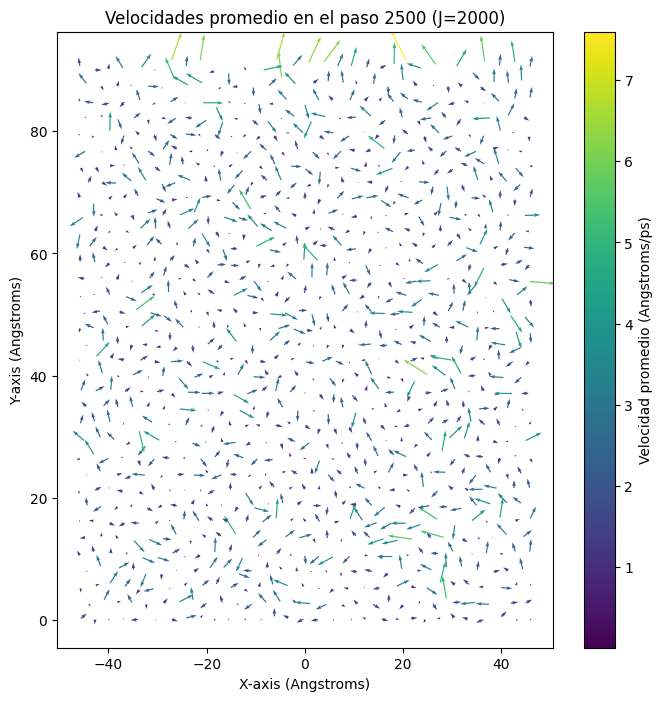

Tiempo actual en la simulacion! :  0.26
Maximo valor en la acelaracion:  53811.639923445124
Minimo valor en la acelaracion:  0.0
Energia promedio del sistema:  1.1269777434733347e-23  Joules.


Tiempo actual en la simulacion! :  0.27
Maximo valor en la acelaracion:  53004.849676161975
Minimo valor en la acelaracion:  0.0
Energia promedio del sistema:  1.1413053768132876e-23  Joules.


Tiempo actual en la simulacion! :  0.28
Maximo valor en la acelaracion:  51559.00478047813
Minimo valor en la acelaracion:  0.0
Energia promedio del sistema:  1.1544979198768085e-23  Joules.


Tiempo actual en la simulacion! :  0.29000000000000004
Maximo valor en la acelaracion:  49210.038354306686
Minimo valor en la acelaracion:  0.0
Energia promedio del sistema:  1.1688096472068348e-23  Joules.


Tiempo actual en la simulacion! :  0.3
Maximo valor en la acelaracion:  51943.122287536986
Minimo valor en la acelaracion:  5.769861897301142
Energia promedio del sistema:  1.176554303772072e-23  Joules.


Tiem

<Figure size 640x480 with 0 Axes>

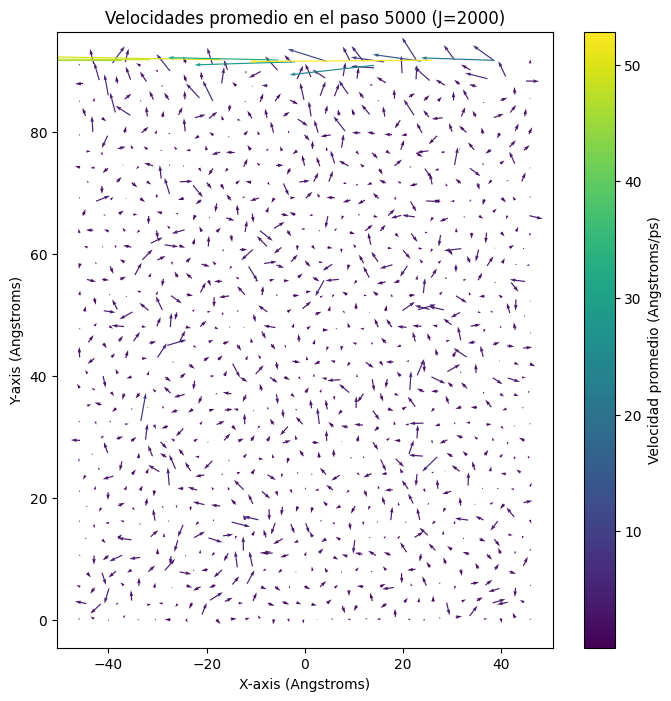

Tiempo actual en la simulacion! :  0.51
Maximo valor en la acelaracion:  63386.31325228753
Minimo valor en la acelaracion:  0.0
Energia promedio del sistema:  1.301289456317412e-23  Joules.


Tiempo actual en la simulacion! :  0.52
Maximo valor en la acelaracion:  71850.1727132057
Minimo valor en la acelaracion:  0.0
Energia promedio del sistema:  1.3019188390853858e-23  Joules.


Tiempo actual en la simulacion! :  0.53
Maximo valor en la acelaracion:  56564.41661795991
Minimo valor en la acelaracion:  0.0
Energia promedio del sistema:  1.3248670870725183e-23  Joules.


Tiempo actual en la simulacion! :  0.54
Maximo valor en la acelaracion:  56108.147124699855
Minimo valor en la acelaracion:  0.0
Energia promedio del sistema:  1.3368844371227444e-23  Joules.


Tiempo actual en la simulacion! :  0.55
Maximo valor en la acelaracion:  64647.78243416172
Minimo valor en la acelaracion:  0.0
Energia promedio del sistema:  1.3434551423982287e-23  Joules.


Tiempo actual en la simulacion! :  0

<Figure size 640x480 with 0 Axes>

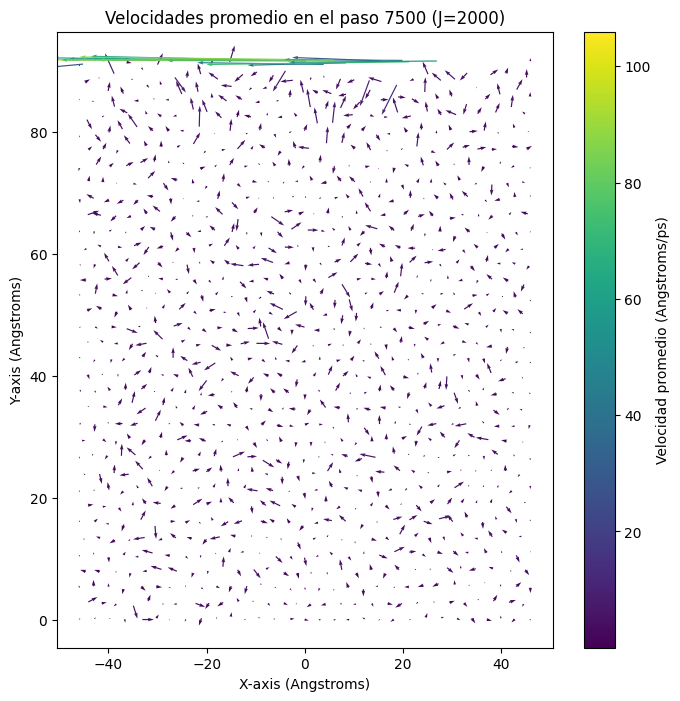

Tiempo actual en la simulacion! :  0.76
Maximo valor en la acelaracion:  89689.73996145686
Minimo valor en la acelaracion:  8.329027627076037
Energia promedio del sistema:  1.4529937374592181e-23  Joules.


Tiempo actual en la simulacion! :  0.77
Maximo valor en la acelaracion:  103096.51232283702
Minimo valor en la acelaracion:  0.0
Energia promedio del sistema:  1.4519213771995037e-23  Joules.


Tiempo actual en la simulacion! :  0.78
Maximo valor en la acelaracion:  85975.78888935345
Minimo valor en la acelaracion:  0.0
Energia promedio del sistema:  1.4376191565121562e-23  Joules.


Tiempo actual en la simulacion! :  0.79
Maximo valor en la acelaracion:  80049.88733359076
Minimo valor en la acelaracion:  0.0
Energia promedio del sistema:  1.4636051071468698e-23  Joules.


Tiempo actual en la simulacion! :  0.8
Maximo valor en la acelaracion:  73768.33304151415
Minimo valor en la acelaracion:  0.0
Energia promedio del sistema:  1.4679925098228597e-23  Joules.


Tiempo actual en la s

<Figure size 640x480 with 0 Axes>

In [7]:
# This is the test change to see if the github connection works

if __name__ == '__main__':
    # Ejemplo de uso:
    import time
    num_bodies = totalParticles
    hstep = h

    # Obtén posición inicial
    bodies_dataX = getInitialPositions((-cuadrantLength, 0.0), (-cuadrantLength + row1_dx*0.5, rows_dy),\
            row1_dx, rows_dy, row1_part, num_bodies)

    # Obtén velocidad inicial
    bodies_dataV = getInitialVelocities(vp, num_bodies)
    startIndex=0

    print("Forma de la información de X: ",bodies_dataX.shape)
    print("Forma de la información de V: ",bodies_dataV.shape)

    # Obtén las aceleraciones en función de las posiciones (Recordemos que la fuerza, ergo la aceleración está solo en función de la posición)
    bodies_dataA = compute_net_forces_parallel(bodies_dataX)

    startIndex = startIndex*frameIterSep
    #print("Tiempo actual en la simulacion! : ", (startIndex*hstep))
    #print("Maximo valor en la aceleracion: ", (np.max(bodies_dataA[:,0]**2 + bodies_dataA[:,1]**2)))
    #print("Minimo valor en la aceleracion: ", (np.min(bodies_dataA[:,0]**2 + bodies_dataA[:,1]**2)))
    
    velocidades = np.sqrt(bodies_dataV[:,0]**2 + bodies_dataV[:,1]**2)
    velocidadPromedio = (1.0/num_bodies)*np.sum(velocidades)
    
    #print("Energia promedio del sistema: ", (3.0103e-24)*velocidadPromedio, " Joules.")
    # De donde sale el cálculo de esta energia promedio?

    ### Aqui hacemos una mascara, en particular queremos ver quienes son las que son particulas muy rapidas
    mask = velocidades>=0.9*velocidadPromedio
    elementosRapidosX = []
    elementosRapidosV = []
    magnitude = []

    for i in range(len(mask)):
        if mask[i]:
            elementosRapidosX.append(bodies_dataX[i])
            elementosRapidosV.append(bodies_dataV[i])
            magnitude.append(velocidades[i])
    index = int(0)
    filename = 'C:/Users/ivan_/Desktop/Tesis/Python_scripts/Jupyter/V40/quiverPlots/'+ str(index)+'.png'

    # Transformar elementosRapidos a un array por la eficiencia de cálculos
    elementosRapidosV = np.array(elementosRapidosV, dtype=np.float64)
    elementosRapidosX = np.array(elementosRapidosX, dtype=np.float64)

    
    #plt.style.use('dark_background')
    plt.figure(figsize=(16, 16))
    # Se dibujan las paredes del contenedor
    plt.plot([-boxSide/2.0, boxSide/2.0], [0.0, 0.0], color='k')
    plt.plot([boxSide/2.0, boxSide/2.0], [0.0, boxSide], color='k')
    plt.plot([boxSide/2.0, -boxSide/2.0], [boxSide, boxSide], color='k')
    plt.plot([-boxSide/2.0, -boxSide/2.0], [boxSide, 0.0], color='k')
    # Se dibujan las partículas que cumplen la condición de ser rápidas
    plt.quiver(elementosRapidosX[:,0], elementosRapidosX[:,1],
                elementosRapidosV[:,0], elementosRapidosV[:,1],
                magnitude, cmap='viridis')
    plt.colorbar(label='Velocidad (Angstroms/ps)')
    plt.xlabel("X-axis (Angstroms)")
    plt.ylabel("Y-axis (Angstroms)")
    plt.title(f"Simulacion al tiempo {startIndex*h} ps. Particulas veloces")
    plt.savefig(filename)
    plt.clf()
    print("\n")
    
    key_steps=[2500,5000,7500]
    key_steps=np.array(key_steps)
    key_hiter=key_steps/frameIterSep
    jota=2000
    
    # Guardar los datos en archivos binarios
    with open('C:/Users/ivan_/Desktop/Tesis/Python_scripts/Jupyter/V40/serialPositions.bin', 'wb') as sp:
        with open('C:/Users/ivan_/Desktop/Tesis/Python_scripts/Jupyter/V40/serialVelocities.bin', 'wb') as sv:
            with open('C:/Users/ivan_/Desktop/Tesis/Python_scripts/Jupyter/V40/serialTime.bin', 'wb') as st:
                # Arreglo para guardar posiciones y compararlas, se usa para calcular la velocidad promedio J
                pos_guardadas=[]

                frames = 0
                st.write(np.float64(0.0).tobytes())
                sp.write(bodies_dataX.tobytes())
                sv.write(bodies_dataV.tobytes())
                #ahora calculo
                bodies_dataA = compute_net_forces_parallel(bodies_dataX)

                for s in range(startIndex,totalSteps):
                    pos_guardadas.append(np.copy(bodies_dataX))

                    if frames%frameIterSep == 0:
                        st.write(np.float64(s*hstep).tobytes())
                        sp.write(bodies_dataX.tobytes())
                        sv.write(bodies_dataV.tobytes())
                        print("Tiempo actual en la simulacion! : ", (s*hstep))
                        print("Maximo valor en la acelaracion: ", (np.max(bodies_dataA[:,0]**2 + bodies_dataA[:,1]**2)))
                        print("Minimo valor en la acelaracion: ", (np.min(bodies_dataA[:,0]**2 + bodies_dataA[:,1]**2)))
                        velocidades = np.sqrt(bodies_dataV[:,0]**2 + bodies_dataV[:,1]**2)
                        velocidadPromedio = (1.0/num_bodies)*np.sum(velocidades)
                        print("Energia promedio del sistema: ", (3.0103e-24)*velocidadPromedio, " Joules.")
                        ### Aqui hacemos una mascara, en particular queremos ver quienes son las que son particulas muy rapidas
                        mask = velocidades>=0.9*velocidadPromedio
                        elementosRapidosX = []
                        elementosRapidosV = []
                        magnitude = []
                        for i in range(len(mask)):
                            if mask[i]: # Si la mascara es verdad, eso significa que hay una velocidad que si cumple ser mayor que la promedio
                                elementosRapidosX.append(bodies_dataX[i])
                                elementosRapidosV.append(bodies_dataV[i])
                                magnitude.append(velocidades[i])
                        index = s
                        filename = 'C:/Users/ivan_/Desktop/Tesis/Python_scripts/Jupyter/V40/quiverPlots/'+ str(index)+'.png'

                        elementosRapidosV = np.array(elementosRapidosV, dtype=np.float64)
                        elementosRapidosX = np.array(elementosRapidosX, dtype=np.float64)

                        plt.plot([-boxSide/2.0, boxSide/2.0], [0.0, 0.0], color='k')
                        plt.plot([boxSide/2.0, boxSide/2.0], [0.0, boxSide], color='k')
                        plt.plot([boxSide/2.0, -boxSide/2.0], [boxSide, boxSide], color='k')
                        plt.plot([-boxSide/2.0, -boxSide/2.0], [boxSide, 0.0], color='k')
                        plt.quiver(elementosRapidosX[:,0], elementosRapidosX[:,1],
                                        elementosRapidosV[:,0], elementosRapidosV[:,1],
                                        magnitude, cmap='viridis')
                        plt.colorbar(label='Velocidad (Angstroms/ps)')
                        plt.xlabel("X-axis (Angstroms)")
                        plt.ylabel("Y-axis (Angstroms)")
                        plt.title(f"Simulacion al tiempo {hstep*s} ps. Particulas veloces")
                        plt.savefig(filename)
                        plt.clf()
                        print("\n")

                    #Extraer velocidades promedio con el J
                    if s in key_steps:
                        if s >= jota:
                            print("Se está ejecutando esta operación ")
                            pos_actual = pos_guardadas[s]
                            pos_pasadas= pos_guardadas[s-jota]
                            vel_promedioJ= (pos_actual-pos_pasadas) / (jota*hstep)
                            vx = vel_promedioJ[:,0]
                            vy = vel_promedioJ[:,1]

                            plt.figure(figsize=(8, 8))
                            plt.quiver(pos_actual[:, 0], pos_actual[:, 1], vx, vy, np.sqrt(vx**2 + vy**2), cmap='viridis')
                            plt.colorbar(label='Velocidad promedio (Angstroms/ps)')
                            plt.xlabel("X-axis (Angstroms)")
                            plt.ylabel("Y-axis (Angstroms)")
                            plt.title(f"Velocidades promedio en el paso {s} (J={jota})")
                            plt.show()

                            with open('C:/Users/ivan_/Desktop/Tesis/Python_scripts/Jupyter/V40/average_velocitiesJ.bin', 'wb') as av:
                                av.write(np.float64(s * hstep).tobytes())
                                av.write(pos_actual.tobytes())
                                av.write(vel_promedioJ.tobytes())
                            
                            # Orden de guardado -> time > position > velocity
                            #av.write(np.float64(s*hstep).tobytes())
                            #av.write(bodies_dataX.tobytes())
                            #av.write(bodies_dataV.tobytes())
                            
                            # En la próxima línea calcular la fórmula de velocidad promedio con el J incluido, esto se deja para el viernes 15 de agosto
                            # En las próximas líneas tengo que guardar las imágenes de las velocidades promedio de cada uno de 
                            
                        # Aquí aplica el paso de Leapfrog
                    bodies_dataV = bodies_dataV + 0.5*hstep*bodies_dataA
                    bodies_dataX = bodies_dataX + hstep*bodies_dataV
                    bodies_dataX, bodies_dataV = fitInsideParticle(bodies_dataX, bodies_dataV, np.zeros_like(bodies_dataX), np.zeros_like(bodies_dataV))
                    bodies_dataA = compute_net_forces_parallel(bodies_dataX)
                    bodies_dataV = bodies_dataV + 0.5*hstep*bodies_dataA

                    frames += 1
                                    
                st.write(np.float64(totalSteps*hstep).tobytes())
                sp.write(bodies_dataX.tobytes())
                sv.write(bodies_dataV.tobytes())
                pass

    # Time the parallel execution
    start_time = time.time()
    bodies_dataA = compute_net_forces_parallel(bodies_dataX)
    end_time = time.time()
    print(f"Time taken with guvectorize (parallel): {end_time - start_time:.6f} seconds")
